In [24]:
# Data handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

# Preprocessing
from sklearn.model_selection import train_test_split as tts

# Torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.models import vit_b_16, ViT_B_16_Weights

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# os
import os

# OrderedDict
from collections import OrderedDict

# tqdm
from tqdm.auto import tqdm

# Path
from pathlib import Path

# random
import random

# typing
from typing import Dict, List

# warnings
import warnings
warnings.filterwarnings("ignore")

In [25]:
# Total Images
IMAGE_PATH = Path("./archive/files")

# 모든 하위 디렉터리에서 jpg 확장자를 가진 파일 찾기
IMAGE_PATH_LIST = [
    image_path
    for image_path in IMAGE_PATH.glob("*/*/*.jpg")
    if not str(image_path).endswith((".DS_Store", "/.DS_Store"))
]

print(f'Total Images = {len(IMAGE_PATH_LIST)}')

Total Images = 87


In [26]:
# number of images per class. # Get the list of subdirectories (classes)
classes = [d for d in os.listdir(IMAGE_PATH) if os.path.isdir(os.path.join(IMAGE_PATH, d)) and not d.startswith(".")]
classes = sorted(classes)

print("**" * 20)
print(" " * 10, f"Total Classes = {len(classes)}")
print("**" * 20)

for c in classes:
    # Exclude .DS_Store from the list of images
    total_images_class = list(Path(os.path.join(IMAGE_PATH, c)).glob("*/*.jpg"))
    print(f"* {c}: {len(total_images_class)} images")

****************************************
           Total Classes = 3
****************************************
* acne: 30 images
* bags: 27 images
* redness: 30 images


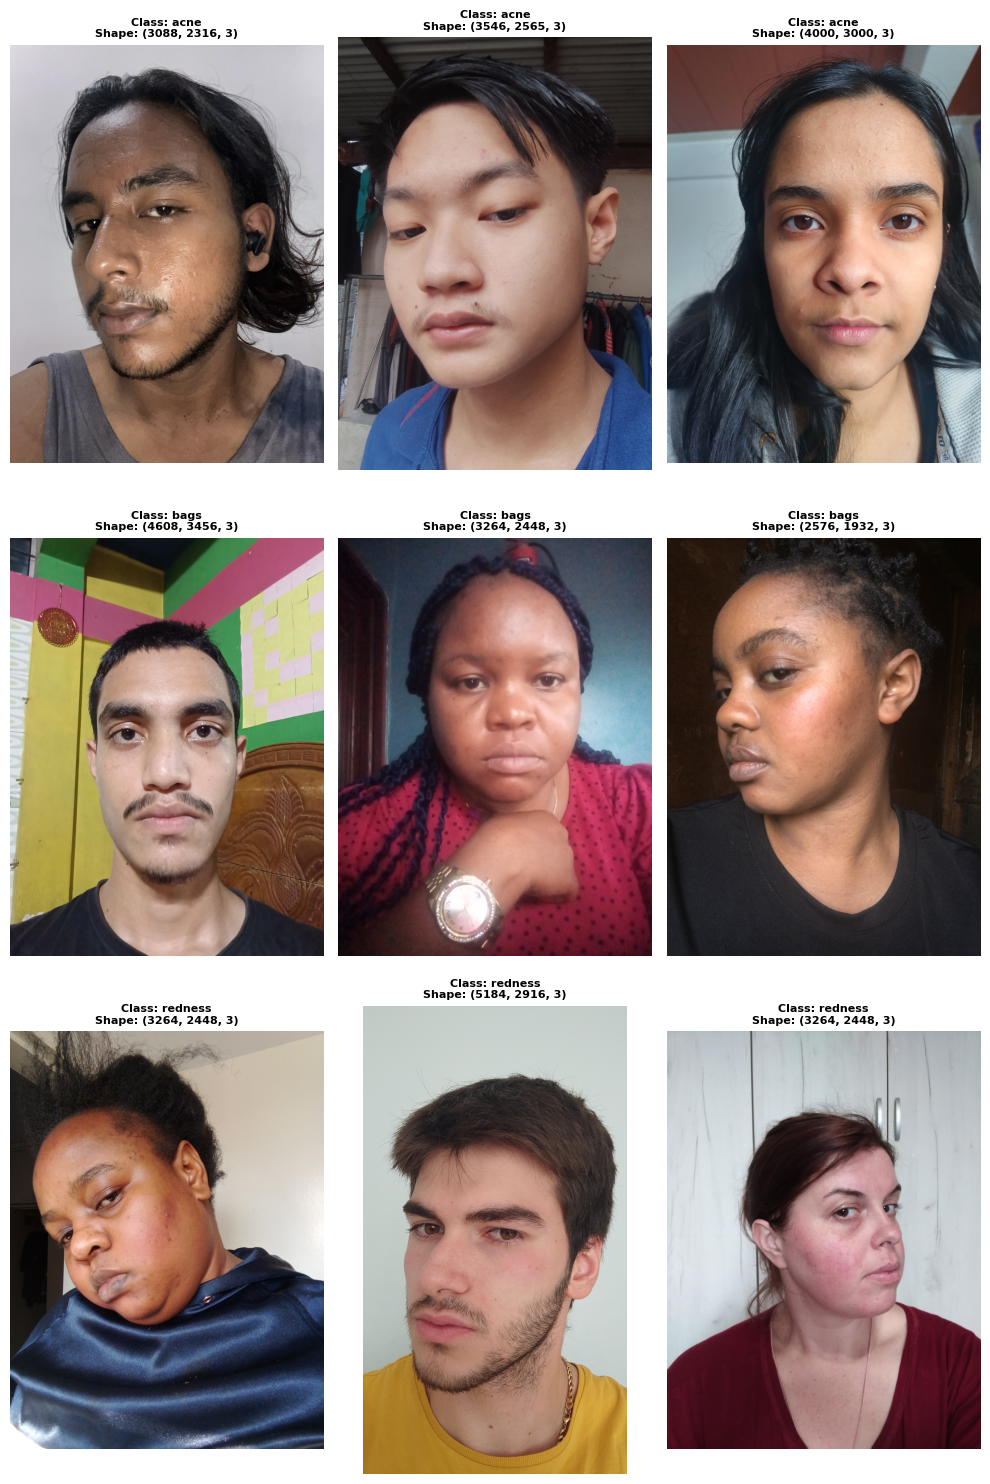

In [27]:
# We view some images for each class.
NUM_IMAGES = 3

# Create subplots for each class and specified number of images
fig, ax = plt.subplots(nrows = len(classes), ncols = NUM_IMAGES, figsize = (10,15))
p = 0
for c in classes:
    total_images_class = list(Path(os.path.join(IMAGE_PATH, c)).glob("*/*.jpg"))
    images_selected = random.choices(total_images_class, k = NUM_IMAGES)
    
    for i,img_path in enumerate(images_selected):
        img_bgr = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        ax[p,i].imshow(img_rgb)
        ax[p,i].axis("off")
        ax[p,i].set_title(f"Class: {c}\nShape: {img_rgb.shape}", fontsize = 8, fontweight = "bold", color = "black")
        
    p += 1
    
fig.tight_layout()
fig.show()

In [28]:
# Create empty lists to store image paths and corresponding labels
images_path = [None] * len(IMAGE_PATH_LIST)
labels = [None] * len(IMAGE_PATH_LIST)

for i,image_path in enumerate(IMAGE_PATH_LIST):
    images_path[i] = image_path
    labels[i] = image_path.parent.parent.stem

# Create a DataFrame using the image paths and labels
df_path_and_label = pd.DataFrame({'path':images_path, 
                                  'label':labels})
df_path_and_label.sample(10)

,path,label
39,archive/files/redness/28/left_side.jpg,redness
78,archive/files/bags/12/left_side.jpg,bags
66,archive/files/bags/16/left_side.jpg,bags
41,archive/files/redness/28/front.jpg,redness
79,archive/files/bags/12/right_side.jpg,bags
0,archive/files/acne/9/left_side.jpg,acne
12,archive/files/acne/1/left_side.jpg,acne
62,archive/files/bags/18/front.jpg,bags
43,archive/files/redness/26/right_side.jpg,redness
14,archive/files/acne/1/front.jpg,acne


In [29]:
#`SEED`: A constant value ensures that the randomization process is reproducible
SEED = 123

#Training set (`df_train`) 70%, Rest of the data (`df_rest`) 30%
#`stratify`: Ensures that the distribution of classes in the training set reflects the original distribution.
df_train, df_rest = tts(df_path_and_label, 
                        test_size = 0.3, 
                        random_state = SEED, 
                        stratify = df_path_and_label["label"])

#Validation set (`df_val`): 50% of the remaining data is allocated for validation.
#Test set (`df_test`): The remaining 50% is used as the test set.
df_val, df_test = tts(df_rest, 
                      test_size = 0.5, 
                      random_state = SEED, 
                      stratify = df_rest["label"])

In [30]:
# We have to define the mapping of the classes to convert the labels to numbers.
label_map = dict(zip(classes, range(0, len(classes))))
label_map

{'acne': 0, 'bags': 1, 'redness': 2}

In [31]:
# Now we define the transformations that we are going to apply.
weights = ViT_B_16_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [32]:
class CustomDataset(Dataset):
    def __init__(self, df:pd.DataFrame, transforms, label_map:dict):
        self.df = df
        self.transforms = transforms
        self.label_map = label_map
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        df_new = self.df.copy()
        df_new = df_new.reset_index(drop = True)
        df_new["label"] = df_new["label"].map(self.label_map)
        image_path = df_new.iloc[idx, 0]
        image = Image.open(image_path).convert("RGB")
        image = self.transforms(image)
        label = df_new.iloc[idx, 1]
        
        return image,label

In [33]:
train_dataset = CustomDataset(df_train, auto_transforms, label_map)
valid_dataset = CustomDataset(df_val, auto_transforms, label_map)

In [38]:
# BATCH_SIZE: 각 미니배치에 포함될 데이터의 개수
# NUM_WORKERS: 데이터를 로드할 때 사용할 병렬 작업 수
BATCH_SIZE = 1

train_dataloader = DataLoader(dataset = train_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True,
                              num_workers=0)
valid_dataloader = DataLoader(dataset = valid_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True,
                              num_workers=0)

In [39]:
# Let's visualize the dimensions of a batch.
# next(iter(train_dataloader)): 훈련 데이터로더에서 다음 미니배치 가져오기
# batch_images, batch_labels: 가져온 미니배치의 이미지와 레이블
batch_images, batch_labels = next(iter(train_dataloader))

batch_images.shape, batch_labels.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1]))

In [40]:
# GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [42]:
#Vision Transformer (ViT) 모델을 생성 : 주로 이미지 분류 작업에 사용되는 트랜스포머(Transformer) 아키텍처를 이미지 처리에 적용한 모델
#모델은 미리 학습된 가중치를 사용
model = vit_b_16(weights = weights)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /Users/infosys/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|████████████████████████████████████████| 330M/330M [01:15<00:00, 4.59MB/s]


In [43]:
# visualize the architecture of the model.
summary(model = model, 
        input_size = [1, 3, 224, 224], #[배치 크기, 채널 수, 높이, 너비]
        col_names = ["input_size", "output_size", "num_params", "trainable"], 
        col_width = 15, 
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224] [1, 1000]       768             True
├─Conv2d (conv_proj)                                         [1, 3, 224, 224] [1, 768, 14, 14] 590,592         True
├─Encoder (encoder)                                          [1, 197, 768]   [1, 197, 768]   151,296         True
│    └─Dropout (dropout)                                     [1, 197, 768]   [1, 197, 768]   --              --
│    └─Sequential (layers)                                   [1, 197, 768]   [1, 197, 768]   --              True
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]   [1, 197, 768]   7,087,872       True
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]   [1, 197, 768]   7,087,872       True
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 197, 768]   [1, 1

In [45]:
#.requires_grad 속성은 해당 파라미터가 학습 중에 역전파를 통해 업데이트되어야 하는지를 나타내는 플래그
for param in model.conv_proj.parameters():
    param.requires_grad = False

In [46]:
for param in model.encoder.parameters():
    param.requires_grad = False

In [47]:
# Let's see if the parameters were frozen.(trainable==false)
summary(model = model, 
        input_size = [1,3,224,224], 
        col_names = ["input_size", "output_size", "num_params", "trainable"], 
        col_width = 15,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224] [1, 1000]       768             Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224] [1, 768, 14, 14] (590,592)       False
├─Encoder (encoder)                                          [1, 197, 768]   [1, 197, 768]   151,296         False
│    └─Dropout (dropout)                                     [1, 197, 768]   [1, 197, 768]   --              --
│    └─Sequential (layers)                                   [1, 197, 768]   [1, 197, 768]   --              False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 197, 768]

In [48]:
#선형 레이어
output_shape = len(classes)

model.heads = nn.Sequential(OrderedDict([('head', nn.Linear(in_features = 768, 
                                                            out_features = output_shape))]))

In [49]:
# One last time let's take a look if the last layer was modified. (Output Shape)
summary(model = model, 
        input_size = [1,3,224,224], 
        col_names = ["input_size", "output_size", "num_params", "trainable"], 
        col_width = 15,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224] [1, 3]          768             Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224] [1, 768, 14, 14] (590,592)       False
├─Encoder (encoder)                                          [1, 197, 768]   [1, 197, 768]   151,296         False
│    └─Dropout (dropout)                                     [1, 197, 768]   [1, 197, 768]   --              --
│    └─Sequential (layers)                                   [1, 197, 768]   [1, 197, 768]   --              False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 197, 768]

In [50]:
#크로스 엔트로피 손실 함수를 생성
#Adam 옵티마이저를 생성합니다. Adam은 경사 하강법의 한 종류로, 학습 중에 모델의 가중치를 업데이트

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [51]:
def train_step(model:torch.nn.Module, 
               dataloader:torch.utils.data.DataLoader, 
               loss_fn:torch.nn.Module, 
               optimizer:torch.optim.Optimizer):
    
    model.train()
    
    train_loss = 0.
    train_accuracy = 0.
    
    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred_logit = model(X)
        loss = loss_fn(y_pred_logit, y)
        train_loss += loss.item()
        
        loss.backward() #손실을 각 파라미터로 미분하고, 이를 통해 각 파라미터에 대한 기울기를 계산
        optimizer.step()
        
        y_pred_prob = torch.softmax(y_pred_logit, dim = 1)  #소프트맥스 함수는 각 클래스에 대한 확률값을 계산하는 함수로, 출력값을 (0, 1) 범위로 변환하며, 모든 클래스에 대한 확률의 합은 1. dim=1은 소프트맥스를 클래스 차원에 적용한다는 의미
        y_pred_class = torch.argmax(y_pred_prob, dim = 1) # y_pred_prob는 소프트맥스 함수를 통과한 결과로, 각 클래스에 대한 확률값을 포함하는 텐서. argmax 함수는 가장 큰 값의 인덱스를 반환하는 함수로, 여기서는 가장 높은 확률을 가지는 클래스의 인덱스를 선택.. dim=1은 클래스 차원에서 최댓값을 찾는다는 의미
        train_accuracy += accuracy_score(y.cpu().numpy(), 
                                         y_pred_class.detach().cpu().numpy())
        
    train_loss = train_loss/len(dataloader)
    train_accuracy = train_accuracy/len(dataloader)
    
    return train_loss, train_accuracy

In [52]:
def save_checkpoint(filename, model, loss, epoch, optimizer, metric):
    state = {"filename":filename, 
             "model":model.state_dict(), 
             "loss":loss, 
             "epoch":epoch, 
             "optimizer":optimizer.state_dict(), 
             "metric":metric}
    
    torch.save(state, filename)

In [53]:
# 검증 단계에서 모델의 성능을 평가하는 함수
def valid_step(model:torch.nn.Module, 
               dataloader:torch.utils.data.DataLoader, 
               loss_fn:torch.nn.Module):
    
    model.eval()
    
    valid_loss = 0.
    valid_accuracy = 0.
    
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device)
            y_pred_logit = model(X)
            loss = loss_fn(y_pred_logit, y)
            valid_loss += loss.item()
            
            y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
            y_pred_class = torch.argmax(y_pred_prob, dim = 1)
            
            valid_accuracy += accuracy_score(y.cpu().numpy(), y_pred_class.detach().cpu().numpy())
            
    valid_loss = valid_loss/len(dataloader)
    valid_accuracy = valid_accuracy/len(dataloader)
    
    return valid_loss, valid_accuracy

In [54]:
def train(model:torch.nn.Module, 
          train_dataloader:torch.utils.data.DataLoader, 
          valid_dataloader:torch.utils.data.DataLoader, 
          loss_fn:torch.nn.Module, 
          optimizer:torch.optim.Optimizer, 
          epochs:int = 10):
    
    results = {"train_loss":[], 
               "train_accuracy":[], 
               "valid_loss":[], 
               "valid_accuracy":[]}
    
    best_valid_loss = float("inf")
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step(model = model, 
                                                dataloader = train_dataloader, 
                                                loss_fn = loss_fn, 
                                                optimizer = optimizer)
        
        valid_loss, valid_accuracy = valid_step(model = model, 
                                                dataloader = valid_dataloader, 
                                                loss_fn = loss_fn)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            file_name = "best_model.pth"
            save_checkpoint(file_name, model, best_valid_loss, epoch, optimizer, valid_accuracy)
            
        print(f"Epoch: {epoch + 1} | ", 
              f"Train Loss: {train_loss:.4f} | ", 
              f"Train Accuracy: {train_accuracy:.4f} | ", 
              f"Valid Loss: {valid_loss:.4f} | ", 
              f"Valid Accuracy: {valid_accuracy:.4f}")
        
        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy)
        results["valid_loss"].append(valid_loss)
        results["valid_accuracy"].append(valid_accuracy)
        
    return results

In [55]:
# Training!!!
EPOCHS = 100

torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

MODEL_RESULTS = train(model.to(device), 
                      train_dataloader, 
                      valid_dataloader, 
                      loss_fn, 
                      optimizer, 
                      EPOCHS)

  1%|▍                                          | 1/100 [00:19<32:23, 19.63s/it]

Epoch: 1 |  Train Loss: 2.9332 |  Train Accuracy: 0.2833 |  Valid Loss: 1.6233 |  Valid Accuracy: 0.3846


  2%|▊                                          | 2/100 [00:38<31:41, 19.41s/it]

Epoch: 2 |  Train Loss: 2.5571 |  Train Accuracy: 0.4500 |  Valid Loss: 1.6015 |  Valid Accuracy: 0.6154


  3%|█▎                                         | 3/100 [00:58<31:19, 19.38s/it]

Epoch: 3 |  Train Loss: 1.9548 |  Train Accuracy: 0.5833 |  Valid Loss: 1.2359 |  Valid Accuracy: 0.5385


  4%|█▋                                         | 4/100 [01:18<31:22, 19.61s/it]

Epoch: 4 |  Train Loss: 0.9231 |  Train Accuracy: 0.8500 |  Valid Loss: 1.0505 |  Valid Accuracy: 0.6923


  5%|██▏                                        | 5/100 [01:37<30:53, 19.51s/it]

Epoch: 5 |  Train Loss: 0.9703 |  Train Accuracy: 0.7167 |  Valid Loss: 0.5285 |  Valid Accuracy: 0.8462


  6%|██▌                                        | 6/100 [01:56<30:17, 19.33s/it]

Epoch: 6 |  Train Loss: 0.4665 |  Train Accuracy: 0.7833 |  Valid Loss: 1.1101 |  Valid Accuracy: 0.6923


  7%|███                                        | 7/100 [02:15<29:46, 19.21s/it]

Epoch: 7 |  Train Loss: 1.0182 |  Train Accuracy: 0.7667 |  Valid Loss: 2.3110 |  Valid Accuracy: 0.6154


  8%|███▍                                       | 8/100 [02:34<29:34, 19.29s/it]

Epoch: 8 |  Train Loss: 0.8511 |  Train Accuracy: 0.7833 |  Valid Loss: 0.2721 |  Valid Accuracy: 0.7692


  9%|███▊                                       | 9/100 [02:53<29:08, 19.21s/it]

Epoch: 9 |  Train Loss: 0.7228 |  Train Accuracy: 0.8500 |  Valid Loss: 0.9785 |  Valid Accuracy: 0.8462


 10%|████▏                                     | 10/100 [03:12<28:42, 19.14s/it]

Epoch: 10 |  Train Loss: 0.6159 |  Train Accuracy: 0.8500 |  Valid Loss: 0.6505 |  Valid Accuracy: 0.8462


 11%|████▌                                     | 11/100 [03:31<28:19, 19.09s/it]

Epoch: 11 |  Train Loss: 0.3626 |  Train Accuracy: 0.8833 |  Valid Loss: 0.8900 |  Valid Accuracy: 0.9231


 12%|█████                                     | 12/100 [03:50<27:57, 19.06s/it]

Epoch: 12 |  Train Loss: 0.0251 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3176 |  Valid Accuracy: 0.9231


 13%|█████▍                                    | 13/100 [04:09<27:36, 19.04s/it]

Epoch: 13 |  Train Loss: 0.0017 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3075 |  Valid Accuracy: 0.9231


 14%|█████▉                                    | 14/100 [04:28<27:17, 19.04s/it]

Epoch: 14 |  Train Loss: 0.0015 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3187 |  Valid Accuracy: 0.9231


 15%|██████                                  | 15/100 [07:45<1:42:50, 72.59s/it]

Epoch: 15 |  Train Loss: 0.0014 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3167 |  Valid Accuracy: 0.9231


 16%|██████▍                                 | 16/100 [08:04<1:18:59, 56.42s/it]

Epoch: 16 |  Train Loss: 0.0013 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3214 |  Valid Accuracy: 0.9231


 17%|██████▊                                 | 17/100 [08:23<1:02:26, 45.13s/it]

Epoch: 17 |  Train Loss: 0.0012 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3240 |  Valid Accuracy: 0.9231


 18%|███████▌                                  | 18/100 [08:42<50:58, 37.29s/it]

Epoch: 18 |  Train Loss: 0.0012 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3294 |  Valid Accuracy: 0.9231


 19%|███████▉                                  | 19/100 [09:01<42:55, 31.80s/it]

Epoch: 19 |  Train Loss: 0.0011 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3312 |  Valid Accuracy: 0.9231


 20%|████████▍                                 | 20/100 [09:20<37:17, 27.96s/it]

Epoch: 20 |  Train Loss: 0.0010 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3365 |  Valid Accuracy: 0.9231


 21%|████████▊                                 | 21/100 [09:39<33:17, 25.28s/it]

Epoch: 21 |  Train Loss: 0.0010 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3360 |  Valid Accuracy: 0.9231


 22%|█████████▏                                | 22/100 [09:58<30:30, 23.47s/it]

Epoch: 22 |  Train Loss: 0.0010 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3413 |  Valid Accuracy: 0.9231


 23%|████████▉                              | 23/100 [26:33<6:43:59, 314.80s/it]

Epoch: 23 |  Train Loss: 0.0009 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3415 |  Valid Accuracy: 0.9231


 24%|█████████                             | 24/100 [42:30<10:43:07, 507.73s/it]

Epoch: 24 |  Train Loss: 0.0009 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3436 |  Valid Accuracy: 0.9231


 25%|█████████▊                             | 25/100 [42:51<7:31:54, 361.53s/it]

Epoch: 25 |  Train Loss: 0.0008 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3449 |  Valid Accuracy: 0.9231


 26%|██████████▏                            | 26/100 [43:10<5:19:20, 258.93s/it]

Epoch: 26 |  Train Loss: 0.0008 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3473 |  Valid Accuracy: 0.9231


 27%|██████████▌                            | 27/100 [43:30<3:47:34, 187.04s/it]

Epoch: 27 |  Train Loss: 0.0008 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3478 |  Valid Accuracy: 0.9231


 28%|██████████▉                            | 28/100 [43:48<2:43:50, 136.53s/it]

Epoch: 28 |  Train Loss: 0.0008 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3507 |  Valid Accuracy: 0.9231


 29%|███████████▎                           | 29/100 [44:07<1:59:44, 101.19s/it]

Epoch: 29 |  Train Loss: 0.0007 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3556 |  Valid Accuracy: 0.9231


 30%|████████████                            | 30/100 [44:26<1:29:11, 76.46s/it]

Epoch: 30 |  Train Loss: 0.0007 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3532 |  Valid Accuracy: 0.9231


 31%|████████████▍                           | 31/100 [44:45<1:08:01, 59.15s/it]

Epoch: 31 |  Train Loss: 0.0007 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3566 |  Valid Accuracy: 0.9231


 32%|█████████████▍                            | 32/100 [45:03<53:19, 47.05s/it]

Epoch: 32 |  Train Loss: 0.0006 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3547 |  Valid Accuracy: 0.9231


 33%|█████████████▊                            | 33/100 [45:22<43:04, 38.58s/it]

Epoch: 33 |  Train Loss: 0.0006 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3606 |  Valid Accuracy: 0.9231


 34%|██████████████▎                           | 34/100 [45:41<35:59, 32.72s/it]

Epoch: 34 |  Train Loss: 0.0006 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3619 |  Valid Accuracy: 0.9231


 35%|█████████████▋                         | 35/100 [54:57<3:25:34, 189.76s/it]

Epoch: 35 |  Train Loss: 0.0006 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3629 |  Valid Accuracy: 0.9231


 36%|██████████████                         | 36/100 [55:17<2:27:53, 138.65s/it]

Epoch: 36 |  Train Loss: 0.0006 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3638 |  Valid Accuracy: 0.9231


 37%|██████████████▍                        | 37/100 [55:38<1:48:27, 103.30s/it]

Epoch: 37 |  Train Loss: 0.0005 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3680 |  Valid Accuracy: 0.9231


 38%|███████████████▏                        | 38/100 [55:58<1:20:52, 78.27s/it]

Epoch: 38 |  Train Loss: 0.0005 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3685 |  Valid Accuracy: 0.9231


 39%|███████████████▌                        | 39/100 [56:18<1:01:54, 60.90s/it]

Epoch: 39 |  Train Loss: 0.0005 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3722 |  Valid Accuracy: 0.9231


 40%|████████████████▊                         | 40/100 [56:38<48:41, 48.69s/it]

Epoch: 40 |  Train Loss: 0.0005 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3659 |  Valid Accuracy: 0.9231


 41%|█████████████████▏                        | 41/100 [56:58<39:19, 39.99s/it]

Epoch: 41 |  Train Loss: 0.0005 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3740 |  Valid Accuracy: 0.9231


 42%|█████████████████▋                        | 42/100 [57:18<32:50, 33.98s/it]

Epoch: 42 |  Train Loss: 0.0004 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3730 |  Valid Accuracy: 0.9231


 43%|██████████████████                        | 43/100 [57:38<28:19, 29.82s/it]

Epoch: 43 |  Train Loss: 0.0004 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3745 |  Valid Accuracy: 0.9231


 44%|██████████████████▍                       | 44/100 [57:58<24:58, 26.77s/it]

Epoch: 44 |  Train Loss: 0.0004 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3782 |  Valid Accuracy: 0.9231


 45%|██████████████████▉                       | 45/100 [58:17<22:33, 24.60s/it]

Epoch: 45 |  Train Loss: 0.0004 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3747 |  Valid Accuracy: 0.9231


 46%|███████████████████▎                      | 46/100 [58:37<20:47, 23.10s/it]

Epoch: 46 |  Train Loss: 0.0004 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3769 |  Valid Accuracy: 0.9231


 47%|███████████████████▋                      | 47/100 [58:56<19:29, 22.06s/it]

Epoch: 47 |  Train Loss: 0.0004 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3779 |  Valid Accuracy: 0.9231


 48%|████████████████████▏                     | 48/100 [59:16<18:31, 21.38s/it]

Epoch: 48 |  Train Loss: 0.0004 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3817 |  Valid Accuracy: 0.9231


 49%|████████████████████▌                     | 49/100 [59:37<18:07, 21.32s/it]

Epoch: 49 |  Train Loss: 0.0003 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3819 |  Valid Accuracy: 0.9231


 50%|█████████████████████                     | 50/100 [59:59<17:49, 21.39s/it]

Epoch: 50 |  Train Loss: 0.0003 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3785 |  Valid Accuracy: 0.9231


 51%|████████████████████▍                   | 51/100 [1:00:19<17:13, 21.09s/it]

Epoch: 51 |  Train Loss: 0.0003 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3825 |  Valid Accuracy: 0.9231


 52%|████████████████████▊                   | 52/100 [1:00:40<16:46, 20.96s/it]

Epoch: 52 |  Train Loss: 0.0003 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3856 |  Valid Accuracy: 0.9231


 53%|█████████████████████▏                  | 53/100 [1:01:00<16:20, 20.86s/it]

Epoch: 53 |  Train Loss: 0.0003 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3856 |  Valid Accuracy: 0.9231


 54%|█████████████████████▌                  | 54/100 [1:01:22<16:06, 21.00s/it]

Epoch: 54 |  Train Loss: 0.0003 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3840 |  Valid Accuracy: 0.9231


 55%|██████████████████████                  | 55/100 [1:01:42<15:40, 20.90s/it]

Epoch: 55 |  Train Loss: 0.0003 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3859 |  Valid Accuracy: 0.9231


 56%|██████████████████████▍                 | 56/100 [1:02:03<15:13, 20.76s/it]

Epoch: 56 |  Train Loss: 0.0003 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3881 |  Valid Accuracy: 0.9231


 57%|██████████████████████▊                 | 57/100 [1:02:24<14:53, 20.77s/it]

Epoch: 57 |  Train Loss: 0.0003 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3859 |  Valid Accuracy: 0.9231


 58%|███████████████████████▏                | 58/100 [1:02:44<14:23, 20.57s/it]

Epoch: 58 |  Train Loss: 0.0003 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3868 |  Valid Accuracy: 0.9231


 59%|███████████████████████▌                | 59/100 [1:03:04<13:58, 20.46s/it]

Epoch: 59 |  Train Loss: 0.0002 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3865 |  Valid Accuracy: 0.9231


 60%|████████████████████████                | 60/100 [1:03:24<13:33, 20.33s/it]

Epoch: 60 |  Train Loss: 0.0002 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3912 |  Valid Accuracy: 0.9231


 61%|████████████████████████▍               | 61/100 [1:03:44<13:09, 20.25s/it]

Epoch: 61 |  Train Loss: 0.0002 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3916 |  Valid Accuracy: 0.9231


 62%|████████████████████████▊               | 62/100 [1:04:04<12:47, 20.20s/it]

Epoch: 62 |  Train Loss: 0.0002 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3917 |  Valid Accuracy: 0.9231


 63%|█████████████████████████▏              | 63/100 [1:04:24<12:27, 20.20s/it]

Epoch: 63 |  Train Loss: 0.0002 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3933 |  Valid Accuracy: 0.9231


 64%|█████████████████████████▌              | 64/100 [1:04:45<12:07, 20.21s/it]

Epoch: 64 |  Train Loss: 0.0002 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3926 |  Valid Accuracy: 0.9231


 65%|██████████████████████████              | 65/100 [1:05:05<11:47, 20.21s/it]

Epoch: 65 |  Train Loss: 0.0002 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3943 |  Valid Accuracy: 0.9231


 66%|██████████████████████████▍             | 66/100 [1:05:25<11:27, 20.21s/it]

Epoch: 66 |  Train Loss: 0.0002 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3942 |  Valid Accuracy: 0.9231


 67%|██████████████████████████▊             | 67/100 [1:05:45<11:06, 20.21s/it]

Epoch: 67 |  Train Loss: 0.0002 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3943 |  Valid Accuracy: 0.9231


 68%|███████████████████████████▏            | 68/100 [1:06:05<10:45, 20.17s/it]

Epoch: 68 |  Train Loss: 0.0002 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3951 |  Valid Accuracy: 0.9231


 69%|███████████████████████████▌            | 69/100 [1:06:26<10:25, 20.17s/it]

Epoch: 69 |  Train Loss: 0.0002 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3939 |  Valid Accuracy: 0.9231


 70%|████████████████████████████            | 70/100 [1:06:46<10:04, 20.15s/it]

Epoch: 70 |  Train Loss: 0.0002 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3958 |  Valid Accuracy: 0.9231


 71%|████████████████████████████▍           | 71/100 [1:07:06<09:43, 20.14s/it]

Epoch: 71 |  Train Loss: 0.0002 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3995 |  Valid Accuracy: 0.9231


 72%|████████████████████████████▊           | 72/100 [1:07:26<09:23, 20.14s/it]

Epoch: 72 |  Train Loss: 0.0002 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3997 |  Valid Accuracy: 0.9231


 73%|█████████████████████████████▏          | 73/100 [1:07:46<09:05, 20.19s/it]

Epoch: 73 |  Train Loss: 0.0002 |  Train Accuracy: 1.0000 |  Valid Loss: 0.4004 |  Valid Accuracy: 0.9231


 74%|█████████████████████████████▌          | 74/100 [1:08:06<08:44, 20.17s/it]

Epoch: 74 |  Train Loss: 0.0002 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3975 |  Valid Accuracy: 0.9231


 75%|██████████████████████████████          | 75/100 [1:08:26<08:23, 20.15s/it]

Epoch: 75 |  Train Loss: 0.0001 |  Train Accuracy: 1.0000 |  Valid Loss: 0.3982 |  Valid Accuracy: 0.9231


 76%|██████████████████████████████▍         | 76/100 [1:08:47<08:04, 20.18s/it]

Epoch: 76 |  Train Loss: 0.0001 |  Train Accuracy: 1.0000 |  Valid Loss: 0.4003 |  Valid Accuracy: 0.9231


 77%|██████████████████████████████▊         | 77/100 [1:09:07<07:44, 20.19s/it]

Epoch: 77 |  Train Loss: 0.0001 |  Train Accuracy: 1.0000 |  Valid Loss: 0.4030 |  Valid Accuracy: 0.9231


 78%|███████████████████████████████▏        | 78/100 [1:09:27<07:25, 20.26s/it]

Epoch: 78 |  Train Loss: 0.0001 |  Train Accuracy: 1.0000 |  Valid Loss: 0.4022 |  Valid Accuracy: 0.9231


 79%|███████████████████████████████▌        | 79/100 [1:09:47<07:05, 20.24s/it]

Epoch: 79 |  Train Loss: 0.0001 |  Train Accuracy: 1.0000 |  Valid Loss: 0.4024 |  Valid Accuracy: 0.9231


 80%|████████████████████████████████        | 80/100 [1:10:08<06:45, 20.26s/it]

Epoch: 80 |  Train Loss: 0.0001 |  Train Accuracy: 1.0000 |  Valid Loss: 0.4014 |  Valid Accuracy: 0.9231


 81%|████████████████████████████████▍       | 81/100 [1:10:28<06:25, 20.30s/it]

Epoch: 81 |  Train Loss: 0.0001 |  Train Accuracy: 1.0000 |  Valid Loss: 0.4024 |  Valid Accuracy: 0.9231


 82%|████████████████████████████████▊       | 82/100 [1:10:49<06:05, 20.32s/it]

Epoch: 82 |  Train Loss: 0.0001 |  Train Accuracy: 1.0000 |  Valid Loss: 0.4026 |  Valid Accuracy: 0.9231


 83%|█████████████████████████████████▏      | 83/100 [1:11:09<05:45, 20.34s/it]

Epoch: 83 |  Train Loss: 0.0001 |  Train Accuracy: 1.0000 |  Valid Loss: 0.4045 |  Valid Accuracy: 0.9231


 84%|█████████████████████████████████▌      | 84/100 [1:11:29<05:25, 20.36s/it]

Epoch: 84 |  Train Loss: 0.0001 |  Train Accuracy: 1.0000 |  Valid Loss: 0.4009 |  Valid Accuracy: 0.9231


 85%|██████████████████████████████████      | 85/100 [1:11:50<05:05, 20.35s/it]

Epoch: 85 |  Train Loss: 0.0001 |  Train Accuracy: 1.0000 |  Valid Loss: 0.4025 |  Valid Accuracy: 0.9231


 86%|██████████████████████████████████▍     | 86/100 [1:12:10<04:44, 20.35s/it]

Epoch: 86 |  Train Loss: 0.0001 |  Train Accuracy: 1.0000 |  Valid Loss: 0.4043 |  Valid Accuracy: 0.9231


 87%|██████████████████████████████████▊     | 87/100 [1:12:30<04:24, 20.37s/it]

Epoch: 87 |  Train Loss: 0.0001 |  Train Accuracy: 1.0000 |  Valid Loss: 0.4070 |  Valid Accuracy: 0.9231


 88%|███████████████████████████████████▏    | 88/100 [1:12:51<04:04, 20.39s/it]

Epoch: 88 |  Train Loss: 0.0001 |  Train Accuracy: 1.0000 |  Valid Loss: 0.4073 |  Valid Accuracy: 0.9231


 89%|███████████████████████████████████▌    | 89/100 [1:13:11<03:44, 20.38s/it]

Epoch: 89 |  Train Loss: 0.0001 |  Train Accuracy: 1.0000 |  Valid Loss: 0.4045 |  Valid Accuracy: 0.9231


 90%|████████████████████████████████████    | 90/100 [1:13:32<03:24, 20.42s/it]

Epoch: 90 |  Train Loss: 0.0001 |  Train Accuracy: 1.0000 |  Valid Loss: 0.4050 |  Valid Accuracy: 0.9231


 91%|████████████████████████████████████▍   | 91/100 [1:13:52<03:03, 20.42s/it]

Epoch: 91 |  Train Loss: 0.0001 |  Train Accuracy: 1.0000 |  Valid Loss: 0.4057 |  Valid Accuracy: 0.9231


 92%|████████████████████████████████████▊   | 92/100 [1:14:13<02:43, 20.44s/it]

Epoch: 92 |  Train Loss: 0.0001 |  Train Accuracy: 1.0000 |  Valid Loss: 0.4038 |  Valid Accuracy: 0.9231


 93%|█████████████████████████████████████▏  | 93/100 [1:14:33<02:22, 20.42s/it]

Epoch: 93 |  Train Loss: 0.0001 |  Train Accuracy: 1.0000 |  Valid Loss: 0.4056 |  Valid Accuracy: 0.9231


 94%|█████████████████████████████████████▌  | 94/100 [1:14:53<02:02, 20.43s/it]

Epoch: 94 |  Train Loss: 0.0001 |  Train Accuracy: 1.0000 |  Valid Loss: 0.4068 |  Valid Accuracy: 0.9231


 95%|██████████████████████████████████████  | 95/100 [1:15:14<01:41, 20.38s/it]

Epoch: 95 |  Train Loss: 0.0001 |  Train Accuracy: 1.0000 |  Valid Loss: 0.4083 |  Valid Accuracy: 0.9231


 96%|██████████████████████████████████████▍ | 96/100 [1:15:34<01:21, 20.37s/it]

Epoch: 96 |  Train Loss: 0.0001 |  Train Accuracy: 1.0000 |  Valid Loss: 0.4032 |  Valid Accuracy: 0.9231


 97%|██████████████████████████████████████▊ | 97/100 [1:15:55<01:01, 20.38s/it]

Epoch: 97 |  Train Loss: 0.0001 |  Train Accuracy: 1.0000 |  Valid Loss: 0.4041 |  Valid Accuracy: 0.9231


 98%|███████████████████████████████████████▏| 98/100 [1:16:15<00:40, 20.37s/it]

Epoch: 98 |  Train Loss: 0.0001 |  Train Accuracy: 1.0000 |  Valid Loss: 0.4064 |  Valid Accuracy: 0.9231


 99%|███████████████████████████████████████▌| 99/100 [1:16:35<00:20, 20.37s/it]

Epoch: 99 |  Train Loss: 0.0001 |  Train Accuracy: 1.0000 |  Valid Loss: 0.4065 |  Valid Accuracy: 0.9231


100%|███████████████████████████████████████| 100/100 [1:16:56<00:00, 46.16s/it]

Epoch: 100 |  Train Loss: 0.0001 |  Train Accuracy: 1.0000 |  Valid Loss: 0.4027 |  Valid Accuracy: 0.9231


In [56]:
# Function to plot the loss and metric during each training epoch.
def loss_metric_curve_plot(model_results:Dict[str,List[float]]):
    
    train_loss = model_results["train_loss"]
    valid_loss = model_results["valid_loss"]
    
    train_accuracy = [float(value) for value in model_results["train_accuracy"]]
    valid_accuracy = [float(value) for value in model_results["valid_accuracy"]]
    
    fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
    axes = axes.flat
    
    axes[0].plot(train_loss, color = "red", label = "Train")
    axes[0].plot(valid_loss, color = "blue", label = "Valid")
    axes[0].set_title("CrossEntropyLoss", fontsize = 12, fontweight = "bold", color = "black")
    axes[0].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].set_ylabel("Loss", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].legend()
    
    axes[1].plot(train_accuracy, color = "red", label = "Train")
    axes[1].plot(valid_accuracy, color = "blue", label = "Valid")
    axes[1].set_title("Metric of performance: Accuracy", fontsize = 12, fontweight = "bold", color = "black")
    axes[1].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].set_ylabel("Score", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].legend()
    
    fig.tight_layout()
    fig.show()

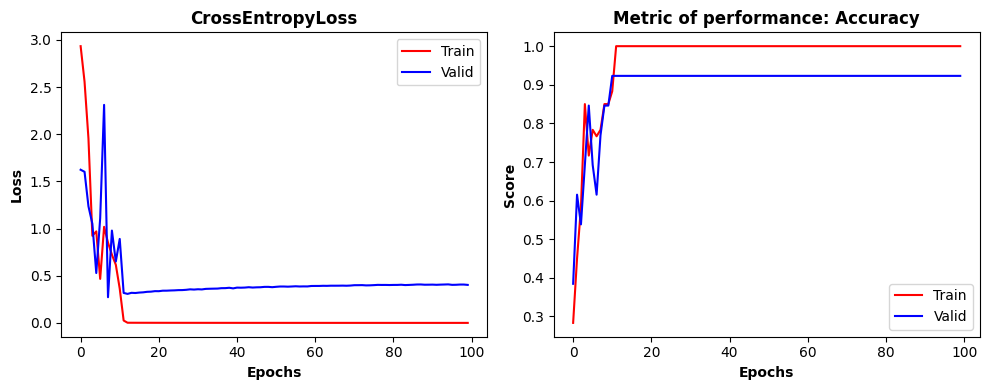

In [57]:
loss_metric_curve_plot(MODEL_RESULTS)

In [58]:
# Let's load the best model.
checkpoint_path = "./best_model.pth"
checkpoint = torch.load(checkpoint_path)

In [59]:
# Now let's look at the smallest loss, its metric and when it occurred.
print(f'Best Loss: {checkpoint["loss"]}')
print(f'Epoch: {checkpoint["epoch"] + 1}')
print(f'Best Metric: {checkpoint["metric"]}')

Best Loss: 0.2721449859851558
Epoch: 8
Best Metric: 0.7692307692307693


In [61]:
# First of all, we create the Dataset, DataLoader
test_dataset = CustomDataset(df_test, auto_transforms, label_map)
test_dataloader = DataLoader(dataset = test_dataset, shuffle = False, num_workers = 0)

In [62]:
# We define the model again with its respective modification.
loaded_model = vit_b_16()

loaded_model.heads = nn.Sequential(OrderedDict([('head',nn.Linear(in_features = 768, 
                                                                  out_features = output_shape))]))

loaded_model.load_state_dict(checkpoint["model"])

# We now infer
loaded_model.to(device)

loaded_model.eval()

y_pred_test = []

with torch.inference_mode():
    for X,y in tqdm(test_dataloader):
        X,y = X.to(device), y.to(device)
        y_pred_logit = loaded_model(X)
        y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
        y_pred_class = torch.argmax(y_pred_prob, dim = 1)
        y_pred_test.append(y_pred_class.detach().cpu())

100%|███████████████████████████████████████████| 14/14 [00:02<00:00,  6.14it/s]


In [63]:
y_pred_test = torch.cat(y_pred_test).numpy()

In [64]:
print(f'Accuracy = {round(accuracy_score(df_test["label"].map(label_map), y_pred_test), 4)}')

Accuracy = 0.7143


In [65]:
confusion_matrix_test = confusion_matrix(df_test["label"].map(label_map), y_pred_test)

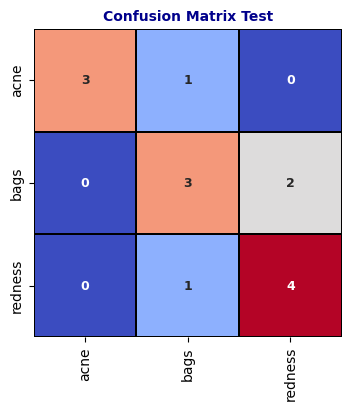

In [66]:
fig,ax = plt.subplots(figsize = (15,4))
sns.heatmap(confusion_matrix_test, 
            cmap = 'coolwarm', 
            annot = True, 
            annot_kws = {"fontsize":9, "fontweight":"bold"}, 
            linewidths = 1.2, 
            linecolor = "black", 
            square = True, 
            xticklabels = classes, 
            yticklabels = classes, 
            cbar = False,
            ax = ax)
ax.set_title("Confusion Matrix Test", fontsize = 10, fontweight = "bold", color = "darkblue")
ax.tick_params('x',rotation = 90)
fig.show()